### Takeaway
- With focus on chronic diseases, the HCC diagnosis features focus on diabetes, dementia, hypertension associated with heart diseases (except end stage and acute), heart arrhythmias and chronic lung disorders.
- In general, Chronic Lung Disorders is an influential conditions that drive patients to use ED services. 
- Diabetes patients are more likely to become high ED utlizers.
- Dementia's lesser impact on ED visits suggests effective management outside can reduce the potential ED utlization.
- Random forest seems to be the choice for predicting furture potenial ED high utlizers, as it assisst people to better implement the corresponding interventions.

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import sqlite3
import pandas as pd
import numpy as np
con = sqlite3.connect("claims.db")

## Section 1- Add features to the models
We will start the work by building the features and add them to the pipeline, where all the training and predicting will happen later.

In [2]:
# Call the initial pipeline
from pipeline_assignment6 import edhuPipeline
pipeline = edhuPipeline("claims.db")
outcome = pipeline.make_outcome()
df = outcome.join(pipeline.make_demo())
df = df.join(pipeline.make_claims_utilization())
df = df.join(pipeline.make_admit())
df = df.join(pipeline.get_costs())
df.head()

,edhu,Age,isFemale,isMainZip,codedRace,er_dates,icu_dates,office_dates,count_specialty,admit_days,cost
patient_id,,,,,,,,,,,
742027e0-da6a-455e-8a3f-5393c10c9aaf,0,72,0,0,5,0,0,0,3,0,710.45
b2045342-368a-4e4d-816c-cc1e7a235233,0,75,0,1,5,0,0,6,7,0,1059.63
ff627004-1542-4d93-bfe7-7729cabfa7f8,0,81,1,0,5,0,0,0,2,0,341.49
6c3409ed-b468-4346-9754-94dc4f042414,0,97,1,1,5,0,0,0,1,0,40136.95
9d5b3602-422e-4e5f-8534-3e7f2b0cf5d1,1,67,1,0,5,2,0,30,32,5,35689.16


In [3]:
len(df)

4930

In [4]:
q = '''
SELECT diagnosis, COUNT(*) AS diagnosis_count
FROM diagnosis
WHERE source = 'ICD10-CM'
GROUP BY diagnosis
ORDER BY diagnosis_count DESC
LIMIT 10;
'''
q = pd.read_sql_query(q, con)
q

,diagnosis,diagnosis_count
0,I10,39074
1,E78.5,16060
2,K21.9,11328
3,E11.9,11270
4,E03.9,10920
5,J44.9,8965
6,I25.10,8940
7,Z79.899,8257
8,E78.2,7043
9,F41.9,5969


Following, we will add HCC features to the pipeline. The method here is to identify one chornic disease first then use the HCC category it belongs to for a further feature building. After testing (not included in the report), this method is more practical than encode single disease as the patient number for specific disease can be too small. 

The selected HCC categories are **17(diabetes), 127(Dementia), 226(Hypertension associated with heart diseases, except end stage and acute), 238(Heart Arrhythmias), 280(Chronic Lung Disorders)**. More detailed grouping information will be attached as comment uring the code. I would also acknowlege that the grouping method is provided by ChatGPT as I do not have related medicine knowledge.

In [5]:
# Specific grouping within each selected HCC category. 
def make_hcc():
    q = '''
    SELECT d.patient_id,
    -- hcc280 encode
    CASE WHEN SUBSTR(d.diagnosis, 0, 4) IN ('J40', 'J41', '42') THEN 1  -- Bronchitis
        WHEN SUBSTR(d.diagnosis, 0, 4) IN ('J43', 'J98') THEN 2  -- Emphysema
        WHEN SUBSTR(d.diagnosis, 0, 4) = 'J44' THEN 3  -- COPD
        WHEN SUBSTR(d.diagnosis, 0, 4) = 'J47' THEN 4  -- Bronchiectasis
        WHEN SUBSTR(d.diagnosis, 0, 4) IN ('J60', 'J61', 'J62', 'J63', 'J64', 'J65', 'J67') THEN 5 -- Pneumoconiosis
        WHEN SUBSTR(d.diagnosis, 0, 4) = 'J68' THEN 6 -- Other respiratory conditions 
        WHEN SUBSTR(d.diagnosis, 0, 4) = 'J84' THEN 7  -- interstitial pulmonary diseases
        WHEN SUBSTR(d.diagnosis, 0, 4) = 'J99' THEN 8  -- Respiratory disorders in diseases classified elsewhere
        WHEN d.diagnosis = 'M32.13' THEN 9  -- Lung involvement in systemic lupus erythematosus
        WHEN d.diagnosis IN ('M33.01', 'M33.11', 'M33.21', 'M33.91') THEN 10 -- Dermatomyositis with respiratory involvement
        ELSE 0  -- Not within HCC 280
    END AS HCC_280,
    -- hcc 127
    CASE WHEN SUBSTR(d.diagnosis, 0, 5) IN ('F01.5', 'F01.A') THEN 1 -- Vascular Dementia
        WHEN SUBSTR(d.diagnosis, 0, 5) IN ('F02.8', 'F02.A') THEN 2 -- Dementia in Other Diseases Classified Elsewhere
        WHEN SUBSTR(d.diagnosis, 0, 5) IN ('F03.9', 'F03.A') THEN 3 -- Unspecified Dementia
        WHEN SUBSTR(d.diagnosis, 0, 4) = 'G30' THEN 4 -- Alzheimer's Disease
        WHEN SUBSTR(d.diagnosis, 0, 4) = 'G31' THEN 5 -- Other Neurocognitive Disorders
        WHEN SUBSTR(d.diagnosis, 0, 4) = 'G91' THEN 6 -- Hydrocephalus
        WHEN SUBSTR(diagnosis, 0, 4) = 'A81' THEN 7  -- Other Related Disorders
        WHEN SUBSTR(diagnosis, 0, 6) IN ('G93.7', 'I67.3') THEN 7  -- Other Related Disorders
        ELSE 0 -- Not within HCC 127
    END AS HCC_127,
    -- hcc 17
    CASE WHEN SUBSTR(d.diagnosis, 0, 6) = 'E10.1' THEN 1 -- Type 1 Diabetes
        WHEN d.diagnosis = 'E10.641' THEN 1 -- Type 1 Diabetes
        WHEN SUBSTR(d.diagnosis, 0, 6) IN ('E11.0', 'E11.1') THEN 2 -- Type 2 Diabetes
        WHEN d.diagnosis = 'E11.641' THEN 2 -- Type 2 Diabetes
        WHEN SUBSTR(d.diagnosis, 0, 6) IN ('E13.0', 'E13.1') THEN 3 -- Other Specified Diabetes
        WHEN d.diagnosis = 'E13.641' THEN 3 -- Other Specified Diabetes
        WHEN SUBSTR(d.diagnosis, 0, 6) IN ('E08.0', 'E08.1', 'E09.0', 'E09.1') THEN 4 -- Diabetes due to Underlying Conditions
        WHEN d.diagnosis IN ('E08.641', 'E09.641') THEN 4 -- Diabetes due to Underlying Conditions 
        ELSE 0 -- Not within HCC 17
    END AS HCC_17,
    -- hcc 226
    CASE WHEN SUBSTR(d.diagnosis, 0, 6) IN ('I11.0', 'I13.0', 'I13.2') THEN 1 -- Hypertension and Related Heart Diseases
        WHEN d.diagnosis = 'I10' THEN 1 -- Hypertension and Related Heart Diseases
        WHEN SUBSTR(d.diagnosis, 0, 4) IN ('I27', 'I28') THEN 2 --  Pulmonary Hypertension
        WHEN SUBSTR(d.diagnosis, 0, 6) IN ('I50.1', 'I50.9') THEN 3 -- Heart Failure
        WHEN d.diagnosis IN ('E13.641', 'I09.81', 'I50.20', 'I50.22', 'I50.30', 'I50.32', 'I50.40', 'I50.42', 
                            'I50.810', 'I50.812', 'I50.814', 'I50.82', 'I50.83', 'I50.89') THEN 3 -- Heart Failure
        ELSE 0 -- Not within HCC 226
    END AS HCC_226,
    -- hcc 238
    CASE WHEN SUBSTR(d.diagnosis, 0, 6) IN ('I47.0', 'I47.2') THEN 1 -- Ventricular Arrhythmias
        WHEN d.diagnosis = 'I47.9' THEN 2 -- Paroxysmal Tachycardia
        WHEN d.diagnosis = 'I48.0' THEN 3 -- Atrial Fibrillation
        WHEN SUBSTR(d.diagnosis, 0, 7) IN  ('I48.11', 'I48.19', 'I48.20', 'I48.21', 'I48.91') THEN 3 -- Atrial Fibrillation
        WHEN SUBSTR(d.diagnosis, 0, 6) IN ('I48.3', 'I48.4') THEN 4 -- Atrial Flutter
        WHEN SUBSTR(d.diagnosis, 0, 7) = 'I48.92' THEN 4 -- Atrial Flutter
        WHEN SUBSTR(d.diagnosis, 0, 6) IN ('I49.2', 'I49.5', 'I44.2') THEN 5 -- Other Cardiac Arrhythmias
        ELSE 0 -- Not within HCC 238
    END AS HCC_238
    FROM diagnosis AS d
    GROUP BY d.patient_id;
    '''
    return pd.read_sql_query(q, con).set_index('patient_id')
hcc = make_hcc()
hcc

,HCC_280,HCC_127,HCC_17,HCC_226,HCC_238
patient_id,,,,,
00079569-795e-493d-83fe-0273a825118c,0,0,0,0,0
0040bbaf-2b4f-4ac2-9148-ec9e072e0fa7,0,0,0,0,0
00617c69-a583-4d12-bfb1-1a46f36cff5a,0,0,0,0,0
009a941d-e32d-4316-a591-1792627b1fac,0,0,0,0,0
009f929a-26c2-44a4-9c4e-8a4402d77501,3,0,0,0,0
...,...,...,...,...,...
ffd064b8-ebf6-4484-af53-426f215f0fdb,0,0,0,1,0
ffdd365d-aa01-43d6-a458-88260b00307c,0,0,0,0,0
ffe03fbd-d619-4a2e-9e01-ef39862b444a,0,0,0,0,0


In [6]:
hcc.apply(pd.value_counts)

,HCC_280,HCC_127,HCC_17,HCC_226,HCC_238
0,4838.0,4922.0,4928.0,4490.0,4882.0
1,9.0,NaN,1.0,406.0,3.0
2,9.0,NaN,NaN,5.0,NaN
3,69.0,NaN,NaN,28.0,38.0
4,NaN,3.0,NaN,NaN,1.0
5,NaN,4.0,NaN,NaN,5.0
7,4.0,NaN,NaN,NaN,NaN


In this step, we count the numbers for each unique values under the variables within the HCC dadtaframe, in a more readable way. 'NaN' means 0.

In [7]:
# Add the HCC features to exisiting pipeline
df1 = df.join(hcc)
df1.head()

,edhu,Age,isFemale,isMainZip,codedRace,er_dates,icu_dates,office_dates,count_specialty,admit_days,cost,HCC_280,HCC_127,HCC_17,HCC_226,HCC_238
patient_id,,,,,,,,,,,,,,,,
742027e0-da6a-455e-8a3f-5393c10c9aaf,0,72,0,0,5,0,0,0,3,0,710.45,0.0,0.0,0.0,1.0,0.0
b2045342-368a-4e4d-816c-cc1e7a235233,0,75,0,1,5,0,0,6,7,0,1059.63,0.0,0.0,0.0,0.0,0.0
ff627004-1542-4d93-bfe7-7729cabfa7f8,0,81,1,0,5,0,0,0,2,0,341.49,0.0,0.0,0.0,0.0,0.0
6c3409ed-b468-4346-9754-94dc4f042414,0,97,1,1,5,0,0,0,1,0,40136.95,0.0,5.0,0.0,0.0,0.0
9d5b3602-422e-4e5f-8534-3e7f2b0cf5d1,1,67,1,0,5,2,0,30,32,5,35689.16,0.0,0.0,0.0,0.0,0.0


In [8]:
df1 = df1.dropna()
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

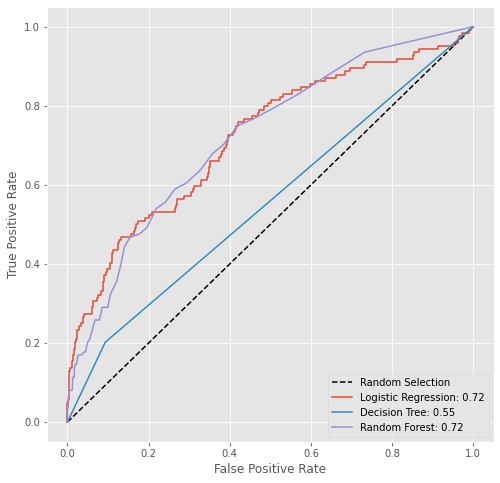

In [9]:
# Initial models
features = ['Age', 'isFemale', 'isMainZip', 'codedRace', 'er_dates', 'icu_dates', 'office_dates', 'count_specialty', 'admit_days', 'cost', 'HCC_280', 'HCC_127', 'HCC_17', 'HCC_226', 'HCC_238']
X_train, X_test, y_train, y_test = train_test_split(df1[features], df1['edhu'], test_size=.25, random_state=42)

# LR Fit
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test.astype(int), lr.predict_proba(X_test)[:,1])
lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

# DT Fit
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test.astype(int), dt.predict_proba(X_test)[:,1])
dt_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:,1])

# RF Fit
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.astype(int), rf.predict_proba(X_test)[:,1])
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

# Plot
fig, ax = plt.subplots(figsize=(8,8))
ax.plot([0,1], [0,1], c='k', linestyle='--', label='Random Selection')
ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression: {lr_auc:0.2f}')
ax.plot(fpr_dt, tpr_dt, label=f'Decision Tree: {dt_auc:0.2f}')
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest: {rf_auc:0.2f}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
_ = ax.legend(loc='lower right')

With the initial models built, it is easily to notice that all of the models are built under a default parameters. As this might affect the model to reach its best performance, an optimiztion on the parameters is needed. 

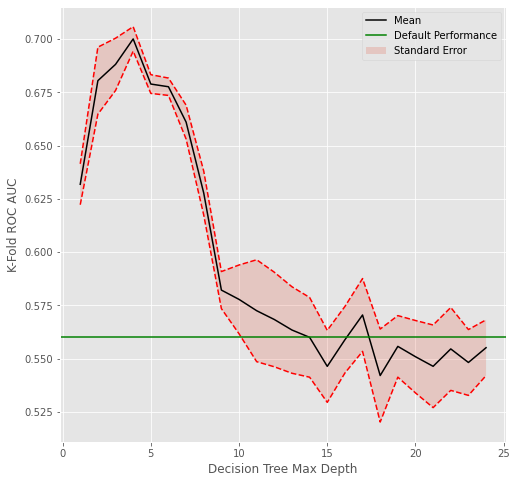

In [10]:
# Optimization

# dt parameters 
dt_opt = DecisionTreeClassifier() 
depths = [x for x in range(1, 25)]
tuned_parameters = [{"max_depth": depths}]
n_folds = 5 # k-folds


clf = GridSearchCV(dt_opt, tuned_parameters, cv=n_folds, scoring='roc_auc') 
clf.fit(X_train, y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

std_error = scores_std / np.sqrt(n_folds)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(depths, scores, 'k', label='Mean')
ax.plot(depths, scores + std_error, "r--")
ax.plot(depths, scores - std_error, "r--")
ax.axhline(.56, c='g', label='Default Performance')
ax.fill_between(depths,  scores + std_error, scores - std_error, alpha=0.2, label='Standard Error')
ax.set_ylabel("K-Fold ROC AUC")
ax.set_xlabel("Decision Tree Max Depth")
_ = ax.legend(loc='upper right')


In [11]:
dt_opt = DecisionTreeClassifier() 
depths = [x for x in range(1, 25)]
tuned_parameters = [{"max_depth": depths, "class_weight":[None, 'balanced']}]
n_folds = 5 # k-folds

clf = GridSearchCV(dt_opt, tuned_parameters, cv=n_folds, scoring='roc_auc') 
_ = clf.fit(X_train, y_train)
clf.best_score_, clf.best_params_

(0.7024243568608552, {'class_weight': 'balanced', 'max_depth': 2})

Combining the plot and the result of grid search, the best depth for decision tree will be 4 and the `class_weight` will be balanced.

Best Parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
Best Score for Random Forest: 0.7254152382552604


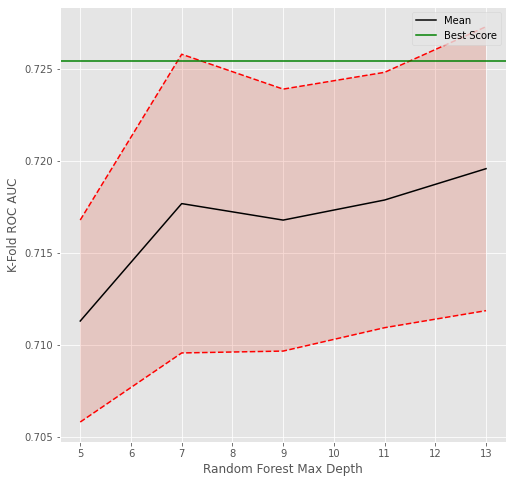

In [22]:
# rf parameters
param_grid_rf = {
    'max_depth': [3, 5, 7, 9, 11, 13],  
    'n_estimators': [10, 30, 50, 100, 300],
    'min_samples_leaf': [1, 5, 10]
}

rf_opt = RandomForestClassifier()
n_folds = 5

rf_clf = GridSearchCV(estimator=rf_opt, param_grid=param_grid_rf, cv=n_folds, scoring='roc_auc')
rf_clf.fit(X_train, y_train)

# Get the best parameters and score
best_params_rf = rf_clf.best_params_
best_score_rf = rf_clf.best_score_
print("Best Parameters for Random Forest:", best_params_rf)
print("Best Score for Random Forest:", best_score_rf)

# Plot 
depths = [3, 5, 7, 9, 11, 13]
scores_rf_max_depth = rf_clf.cv_results_['mean_test_score'][:len(depths)]
std_rf_max_depth = rf_clf.cv_results_['std_test_score'][:len(depths)]
std_error_rf_max_depth = std_rf_max_depth / np.sqrt(n_folds)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(depths, scores_rf_max_depth, 'k', label='Mean')
ax.plot(depths, scores_rf_max_depth + std_error_rf_max_depth, "r--")
ax.plot(depths, scores_rf_max_depth - std_error_rf_max_depth, "r--")
ax.axhline(best_score_rf, c='g', label='Best Score')
ax.fill_between(depths,  scores_rf_max_depth + std_error_rf_max_depth, scores_rf_max_depth - std_error_rf_max_depth, alpha=0.2)
ax.set_ylabel("K-Fold ROC AUC")
ax.set_xlabel("Random Forest Max Depth")
ax.legend(loc='upper right')
plt.show()

Combining the plot and the result of grid search, the best depth will be 13, the `min_samples_leaf` will be 10 and `n_estimators` will be 50.

Best Parameters for Logistic Regression: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}
Best Score for Logistic Regression: 0.7072449783154531


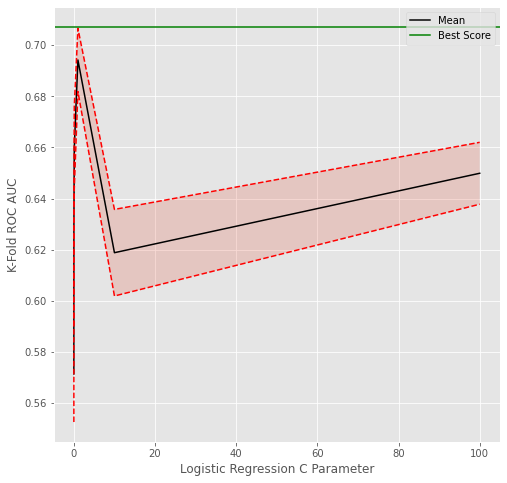

In [13]:
# Optimization - lr
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2'], 
    'class_weight': [None, 'balanced']  
}

lr_opt = LogisticRegression(solver='liblinear')
n_folds = 5

lr_clf = GridSearchCV(estimator=lr_opt, param_grid=param_grid_lr, cv=n_folds, scoring='roc_auc')
lr_clf.fit(X_train, y_train)

best_params_lr = lr_clf.best_params_
best_score_lr = lr_clf.best_score_
print("Best Parameters for Logistic Regression:", best_params_lr)
print("Best Score for Logistic Regression:", best_score_lr)

# Plot
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
scores_lr_C = lr_clf.cv_results_['mean_test_score'][:len(Cs)]
std_lr_C = lr_clf.cv_results_['std_test_score'][:len(Cs)]
std_error_lr_C = std_lr_C / np.sqrt(n_folds)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(Cs, scores_lr_C, 'k', label='Mean')
ax.plot(Cs, scores_lr_C + std_error_lr_C, "r--")
ax.plot(Cs, scores_lr_C - std_error_lr_C, "r--")
ax.axhline(best_score_lr, c='g', label='Best Score')
ax.fill_between(Cs,  scores_lr_C + std_error_lr_C, scores_lr_C - std_error_lr_C, alpha=0.2)
ax.set_ylabel("K-Fold ROC AUC")
ax.set_xlabel("Logistic Regression C Parameter")
ax.legend(loc='upper right')
plt.show()

Combining the plot and the result of grid search, the C will be 1, the `class_weight` will be balanced and `penality` will l1 type. Retrain as below

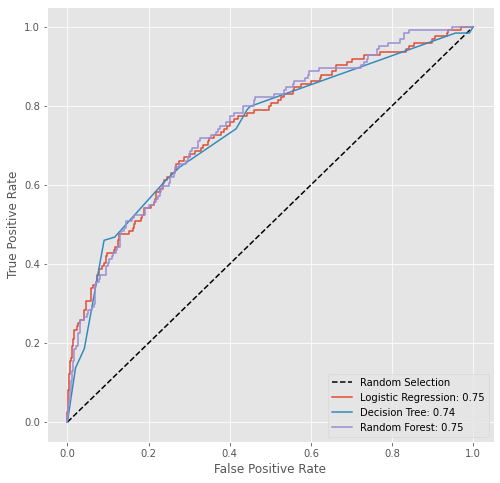

In [27]:
# DT with optimization
dt = DecisionTreeClassifier(max_depth = 4, class_weight = 'balanced')
dt.fit(X_train, y_train)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test.astype(int), dt.predict_proba(X_test)[:,1])
dt_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:,1])

# RF with optimization
best_rf = RandomForestClassifier(max_depth= 13, min_samples_leaf= 10, n_estimators= 50)
best_rf.fit(X_train, y_train)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.astype(int), best_rf.predict_proba(X_test)[:, 1])
rf_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

#LR with optimization
best_lr = LogisticRegression(solver='liblinear', C=1, class_weight='balanced', penalty='l1')
best_lr.fit(X_train, y_train)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test.astype(int), best_lr.predict_proba(X_test)[:, 1])
lr_auc = roc_auc_score(y_test, best_lr.predict_proba(X_test)[:, 1])

# Plot
fig, ax = plt.subplots(figsize=(8,8))
ax.plot([0,1], [0,1], c='k', linestyle='--', label='Random Selection')
ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression: {lr_auc:0.2f}')
ax.plot(fpr_dt, tpr_dt, label=f'Decision Tree: {dt_auc:0.2f}')
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest: {rf_auc:0.2f}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
_ = ax.legend(loc='lower right')

With the hyperparameter optimization, the logistic regression model and random forest model has been improved. Logistic regression improves from 0.72 to 0.75. Random forest increases to 0.75 as well. As random forest is an ensemble model composed of multiple decision trees, the parameters optimization on decision tree also benefit the random forest as well. 

With testing different parameters of random forest, the current parameters will provide best performance specidically focus on the left down corner. WHen `max_depth` increase and more number of samples required to be at a leaf node, the random forest seems to have a better TF rate.

#### 1.1 Compare the your random forest hyper-parameters to the version of the model trained in class. Do the ideal parameters change with the introduction of new features?

Yes. The best `max_depth` has increased to 13 instead of remain at 3. And the `n_estimators` has dropped to 50 from 300. The increase in max depth means the trees can grow deeper, which now the trees can capture more complex relationships in the data. This proves that the introduction of HCC features has indeed provide valuable additional information to the model. The decrease on the number of estimators suggests that we should consider to reduce the complexity of the ensemble model (by training less trees) in order to avoid overfitting as we now have certain amount of influential features. The change on `min_samples_leaf` hyperparameter further supports the considertion of model complexity and usability is needed as powerful features being added. 

#### 1.2 Compare the performance of your newly trained models to the version trained in the 'Random Forest' Lecture. Which model benefits more from the introduction of new features?

THe new trained model seems to benefit more as it has an overall greater boost of ROCAUC score. This proves that the chornic diseases did have a realtively impact in affecting a patient to utilize the ED services. 

## Section 2- Examine Feature Importances

This section will mainly focus on the feature importance, using the logistic regression. Starting by checking the coefficients of features, we will then apply stanard scaler on them and compare the difference before and after scaling. `SHAP` is used for calculating random forest's features importance. 

In [28]:
lr.coef_[0]

array([-2.42478371e-02, -7.42898736e-04, -1.71927921e-01, -9.15424332e-02,
        3.83229821e-01, -3.68655376e-01,  1.42794204e-02,  4.51347060e-02,
       -1.68189612e-02,  2.02163128e-06,  2.03790368e-01, -3.70918324e-02,
        4.78065759e-02, -2.52387421e-02,  1.72644448e-01])

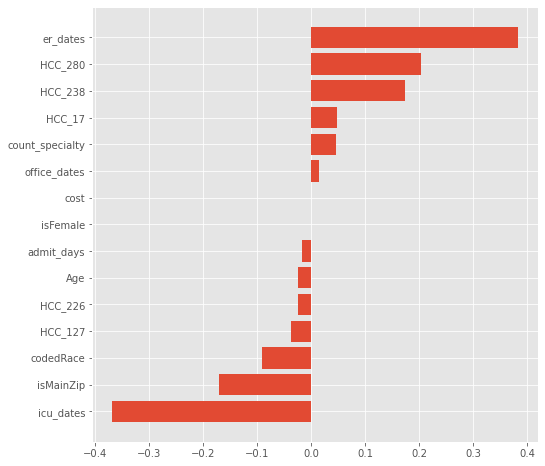

In [29]:
f_imps = sorted(zip(features, lr.coef_[0]), key=lambda x: x[1])

fig, ax = plt.subplots(figsize=(8,8))
p = ax.barh([x[0] for x in f_imps], [x[1] for x in f_imps])

[7.14331710e+01 5.92532468e-01 6.07683983e-01 4.71266234e+00
 5.04058442e-01 4.00432900e-02 7.01082251e+00 6.95698052e+00
 8.87445887e-01 8.46507527e+03 4.78896104e-02 4.87012987e-03
 2.70562771e-04 1.01190476e-01 3.11147186e-02]


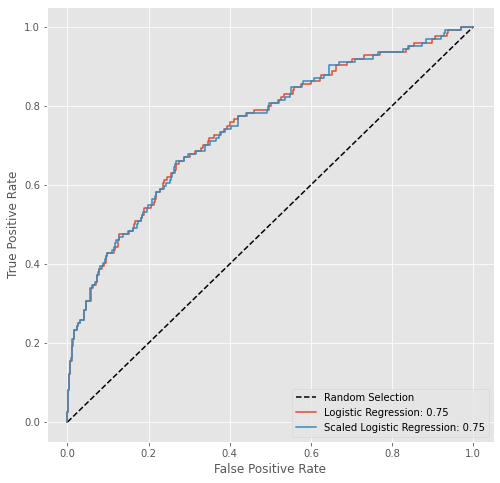

In [30]:
from sklearn.preprocessing import StandardScaler
#X_train, X_test, y_train, y_test
scaler = StandardScaler()
scaler.fit(X_train)
print(scaler.mean_)

lr_scaled = LogisticRegression(solver='liblinear', C=1, class_weight='balanced', penalty='l1')
lr_scaled.fit(scaler.transform(X_train), y_train)
fpr_lrs, tpr_lrs, thresholds_lrs = roc_curve(y_test.astype(int), lr_scaled.predict_proba(scaler.transform(X_test))[:,1])
lrs_auc = roc_auc_score(y_test, lr_scaled.predict_proba(scaler.transform(X_test))[:,1])

# Plot - Demonstrate scaling data does not harm performance
fig, ax = plt.subplots(figsize=(8,8))
ax.plot([0,1], [0,1], c='k', linestyle='--', label='Random Selection')
ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression: {lr_auc:0.2f}')
ax.plot(fpr_lrs, tpr_lrs, label=f'Scaled Logistic Regression: {lrs_auc:0.2f}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
_ = ax.legend(loc='lower right')

Text(0.5, 0, 'icu_dates')

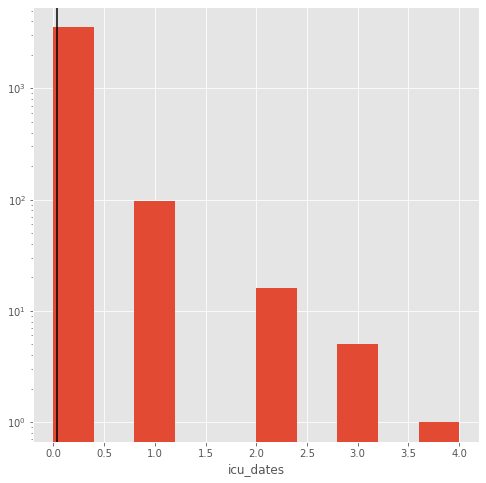

In [31]:
# Fit logistic regression with scaled data
lr_scaled = LogisticRegression(solver='liblinear', C=1, class_weight='balanced', penalty='l1')
lr_scaled.fit(scaler.transform(X_train), y_train)

# Plot histograms of 'icu_dates' feature
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(X_train['icu_dates'])
ax.axvline(np.mean(X_train['icu_dates']), c='k')
ax.set_yscale('log')
ax.set_xlabel('icu_dates')

Below is the comparsion before vs. after standard scaling.

Text(0.5, 0, 'Coefficient Value, Standard Scaling')

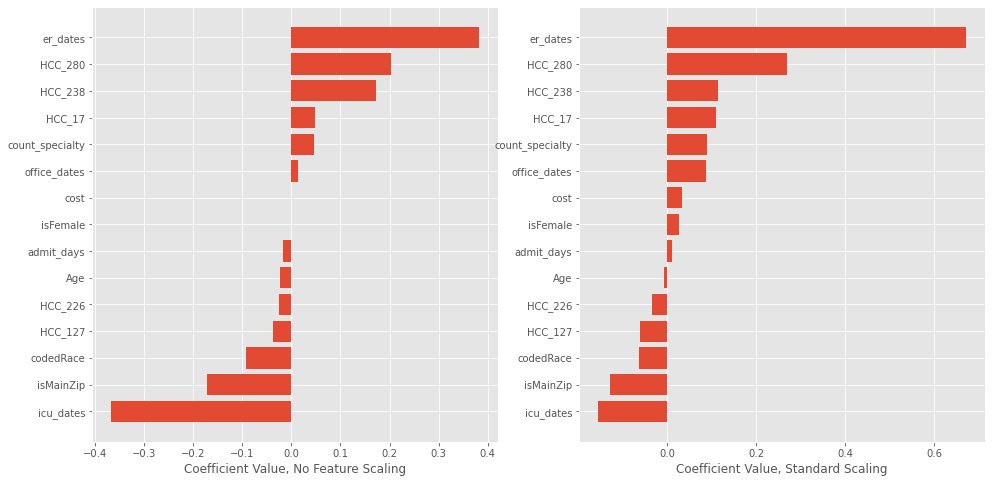

In [32]:
f_imps_scaled = sorted(zip(features, lr_scaled.coef_[0]), key=lambda x: x[1])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].barh([x[0] for x in f_imps], [x[1] for x in f_imps])
ax[0].set_xlabel('Coefficient Value, No Feature Scaling')
ax[1].barh([x[0] for x in f_imps], [x[1] for x in f_imps_scaled])
ax[1].set_xlabel('Coefficient Value, Standard Scaling')

Within the logistic regression model, the new HCC diagnosis features seem to be pretty important. Especially `HCC_280`, `HCC_238` and `HCC_17`. With standard scaling, `HCC_17` demonstrates its importance more. I am pretty surprised by `HCC_17` as only 1 patient in the data frame has been diagnosed having diabetes realted chronic disorders. 

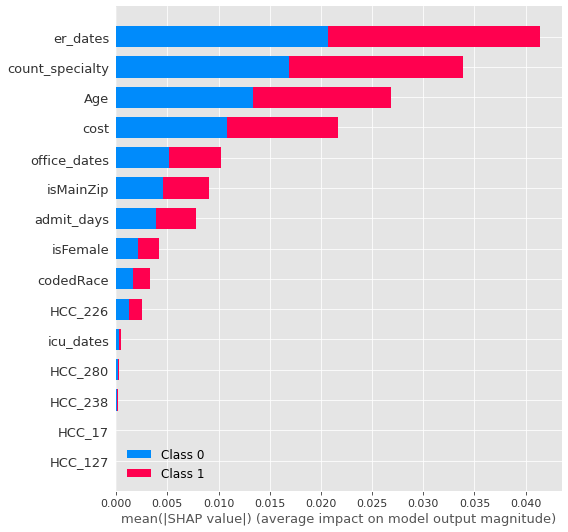

In [52]:
import shap
rf_model = RandomForestClassifier(max_depth= 13, min_samples_leaf= 10, n_estimators= 50)
rf_model.fit(X_train, y_train)
# Calculate SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
# Plot
shap.summary_plot(shap_values, X_train, plot_type='bar')

As we use SHAP to calculate the importance for each feature, red means the feature has more potential in increasing the prediction. HCC_226 appears to have more impact than other HCC features. This could suggest that the chronic health conditions of Hypertension associated with heart diseases captured by HCC_226 are particularly relevant for the model's predictions.

#### 2.1 Which was the most important new diagnosis feature that you added to each models. Is it the same for both, or was one more important than in the other?

By observing both the scaling on logistic regression and the `SHAP` on random forest, it seems that `HCC_280`(Chronic Lung Disorders) has a more inportance in logistic regression while `HCC_226`(Hypertension associated with heart diseases) has a more inportance in random forest. 

#### 2.2 Which is the least important diagnosis feature that you added? Are you surprised that it is the least important feature from those that you added? Why or why not?

Like the most important diagnosis feature, the least important diagnosis feature of these two models happens to be the same one again, which is `HCC_127`(Dementia). I will admit that I was surprised by the result because according to the `value_counts()` on the HCC features, `HCC_17`(diabetes) has the least number of being diagnosed. 

While dementia is a significant health concern, especially for elderly patients, it may not directly contribute to frequent ER visits as much as other chronic conditions. It could mean that our healthcare system provides more resources on dementia and manage them well where patients with dementia will more likely to have regular caregivers managing their healthcare needs outside of the emergency room.

## Section 3 - Build an EDHU 'Bloomer' Model

In this section, we will build model to predict who will likely become the high ED utlizers. 

The first step should be remove the individual who had 3 or more emergency room visits in the 6 months leading up to the prediction date. However, after several failed attempts, I decided to add a `visit_count` of the past 6 months to the pipeline first. Then filtering out patients that made 3 or more visit. 

The code I wrote within the pipeline is listed below. 
```
    def hu_remove(self, er_count: int = 2, date_max: str = "2023-01-01", nDays: int = 182):
        date_max = pd.to_datetime(date_max)
        date_min = date_max - timedelta(days = nDays)
        
        date_min_str = date_min.strftime('%Y-%m-%d')
        date_max_str = date_max.strftime('%Y-%m-%d')
        q = f'''
        SELECT c.patient_id, SUM(edVisit) as visit_count
        FROM claims AS c
        WHERE date BETWEEN DATE("{str(date_min)}") AND DATE("{str(date_max)}")
        GROUP BY patient_id
        '''
        return  pd.read_sql_query(q, self.con).set_index("patient_id")
```

In [34]:
df2 = df1.join(pipeline.hu_remove(er_count=2))
df2.head()

,edhu,Age,isFemale,isMainZip,codedRace,er_dates,icu_dates,office_dates,count_specialty,admit_days,cost,HCC_280,HCC_127,HCC_17,HCC_226,HCC_238,visit_count
patient_id,,,,,,,,,,,,,,,,,
742027e0-da6a-455e-8a3f-5393c10c9aaf,0,72,0,0,5,0,0,0,3,0,710.45,0.0,0.0,0.0,1.0,0.0,0.0
b2045342-368a-4e4d-816c-cc1e7a235233,0,75,0,1,5,0,0,6,7,0,1059.63,0.0,0.0,0.0,0.0,0.0,0.0
ff627004-1542-4d93-bfe7-7729cabfa7f8,0,81,1,0,5,0,0,0,2,0,341.49,0.0,0.0,0.0,0.0,0.0,0.0
6c3409ed-b468-4346-9754-94dc4f042414,0,97,1,1,5,0,0,0,1,0,40136.95,0.0,5.0,0.0,0.0,0.0,0.0
9d5b3602-422e-4e5f-8534-3e7f2b0cf5d1,1,67,1,0,5,2,0,30,32,5,35689.16,0.0,0.0,0.0,0.0,0.0,3.0


In [35]:
df2['visit_count'].unique()

array([ 0.,  3.,  1., nan,  2.,  4.,  5.,  6.,  8.,  7.,  9., 10.])

In [50]:
# filtering out the high ED utlizers
df2 = df2[df2['visit_count'] < 3]
len(df2)

4636

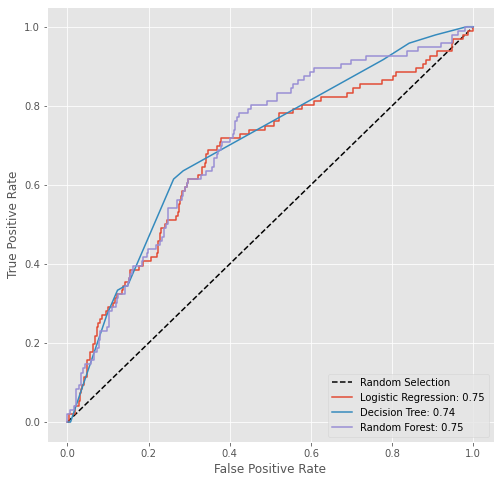

In [51]:
features = ['Age', 'isFemale', 'isMainZip', 'codedRace', 'er_dates', 'icu_dates', 'office_dates', 'count_specialty', 'admit_days', 'cost', 'HCC_280', 'HCC_127', 'HCC_17', 'HCC_226', 'HCC_238']
X_train, X_test, y_train, y_test = train_test_split(df2[features], df2['edhu'], test_size=.25, random_state=42)

# DT 
dt2 = DecisionTreeClassifier(max_depth = 4, class_weight = 'balanced')
dt2.fit(X_train, y_train)
fpr_dt2, tpr_dt2, thresholds_dt2 = roc_curve(y_test.astype(int), dt2.predict_proba(X_test)[:,1])
dt_auc2 = roc_auc_score(y_test, dt2.predict_proba(X_test2)[:,1])

# RF
best_rf2 = RandomForestClassifier(max_depth= 13, min_samples_leaf= 10, n_estimators= 50)
best_rf2.fit(X_train, y_train)
fpr_rf2, tpr_rf2, thresholds_rf2 = roc_curve(y_test.astype(int), best_rf2.predict_proba(X_test)[:, 1])
rf_auc2 = roc_auc_score(y_test, best_rf2.predict_proba(X_test)[:, 1])

#LR 
best_lr2 = LogisticRegression(solver='liblinear', C=1, class_weight='balanced', penalty='l1')
best_lr2.fit(X_train, y_train)
fpr_lr2, tpr_lr2, thresholds_lr2 = roc_curve(y_test.astype(int), best_lr2.predict_proba(X_test)[:, 1])
lr_auc2 = roc_auc_score(y_test, best_lr2.predict_proba(X_test2)[:, 1])

# Plot
fig, ax = plt.subplots(figsize=(8,8))
ax.plot([0,1], [0,1], c='k', linestyle='--', label='Random Selection')
ax.plot(fpr_lr2, tpr_lr2, label=f'Logistic Regression: {lr_auc:0.2f}')
ax.plot(fpr_dt2, tpr_dt2, label=f'Decision Tree: {dt_auc:0.2f}')
ax.plot(fpr_rf2, tpr_rf2, label=f'Random Forest: {rf_auc:0.2f}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
_ = ax.legend(loc='lower right')

Here, I trained the models using the same parameters as previously and got a same ROCAUC result. But if we look down at the left down corner again, it is surprise to find out that random forest model has a higher TF rate than logistic regression while both remaining a low FP rate. 

Random forest model tend to have a higher TF rate compared to logistic regression model when FP rate happen around 0.4 ~ 0.8. This indicates that random forest model might be better at capturing true positives, identifying patients who will use ER a lot successfully, even when the false positive rate is relatively high.

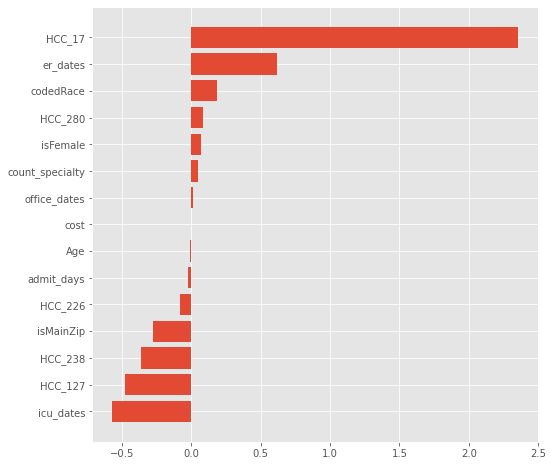

In [39]:
best_lr2.coef_[0]
f_imps2 = sorted(zip(features, best_lr2.coef_[0]), key=lambda x: x[1])

fig, ax = plt.subplots(figsize=(8,8))
p = ax.barh([x[0] for x in f_imps2], [x[1] for x in f_imps2])

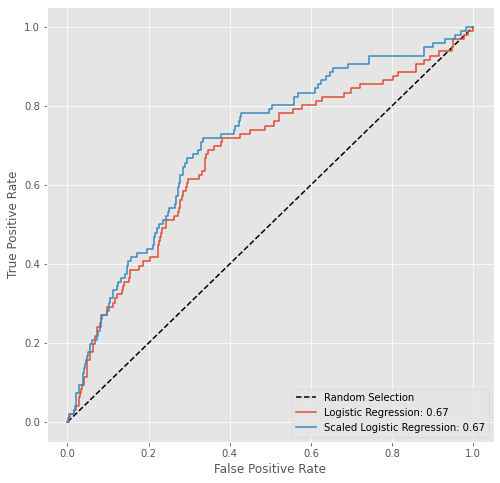

In [40]:
# Transform the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_lr2_scaled = LogisticRegression(solver='liblinear')
best_lr2_scaled.fit(X_train_scaled, y_train)
fpr_lrs2, tpr_lrs2, thresholds_lrs2 = roc_curve(y_test.astype(int), lr_scaled.predict_proba(X_test_scaled)[:, 1])
best_lrs2_auc = roc_auc_score(y_test, best_lr2_scaled.predict_proba(X_test_scaled)[:, 1])

# Plot - Demonstrate scaling data does not harm performance
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], c='k', linestyle='--', label='Random Selection')
ax.plot(fpr_lr2, tpr_lr2, label=f'Logistic Regression: {best_lrs2_auc:0.2f}')
ax.plot(fpr_lrs2, tpr_lrs2, label=f'Scaled Logistic Regression: {best_lrs2_auc:0.2f}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
_ = ax.legend(loc='lower right')

Text(0.5, 0, 'Coefficient Value, Standard Scaling')

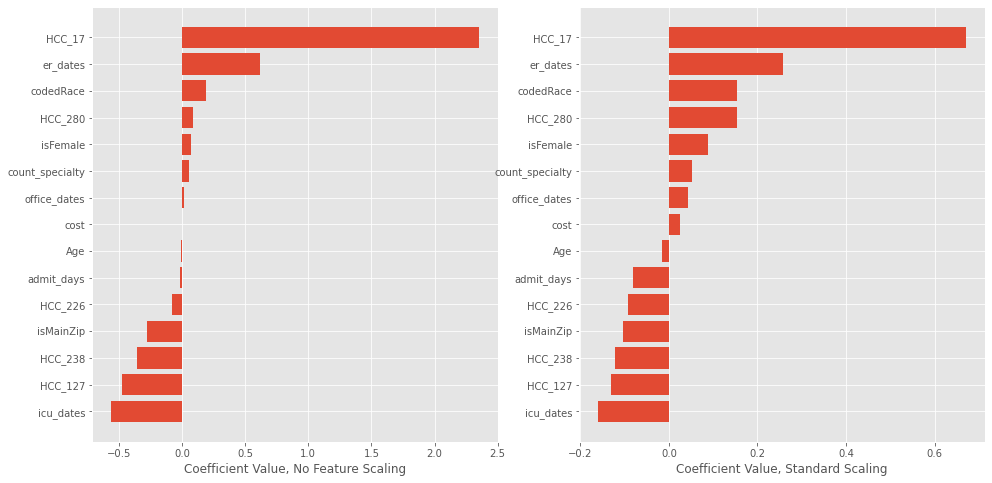

In [41]:
f_imps2_scaled = sorted(zip(features, best_lr2_scaled.coef_[0]), key=lambda x: x[1])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].barh([x[0] for x in f_imps2], [x[1] for x in f_imps2])
ax[0].set_xlabel('Coefficient Value, No Feature Scaling')
ax[1].barh([x[0] for x in f_imps2], [x[1] for x in f_imps2_scaled])
ax[1].set_xlabel('Coefficient Value, Standard Scaling')

In the 'Bloomer' model, HCC 17 becomes the most influential feature. 

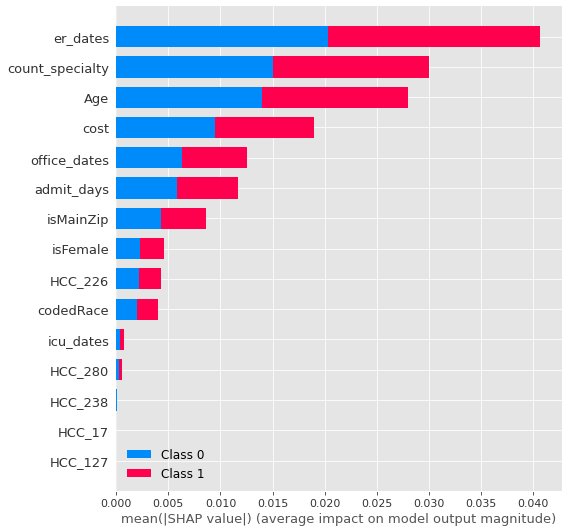

In [46]:
rf_model2 = RandomForestClassifier(max_depth= 13, min_samples_leaf= 10, n_estimators= 50)
rf_model2.fit(X_train, y_train)
# Calculate SHAP values
explainer = shap.TreeExplainer(rf_model2)
shap_values = explainer.shap_values(X_train)
# Plot
shap.summary_plot(shap_values, X_train, plot_type='bar')

#### 3.1 Which model performs better after implementing your new population?

Even the ROCAUC score remains the same as previous, the random forest actually performs better as can be observed from the plot. When predicting the EDHU 'bloomer', it now can capture better true positives which means that the model can identify patients who will use ER a lot correctly. Even with a high FP rate, random forest seems able to capture more TP than the logistic regression. Random forest seems to be the choice for predicting furture potenial ED high utlizers, which can help people to better implement corresponding interventions. 

#### 3.2 Compare the predictions for your updated model to the predictions for the same people on your original models. How does the performance of your new models compare to the performance of the original model on this new population?

There certainly has a shift in terms of the feature importance. I was surprised to find out that `HCC_17` become the most powerful feature in logistic regression for predicting the 'bloomer' of ED high utlizers. This makes sense as `HCC_17` used to be the third mmost important feature in our sction 1 prediction of high ED utlizers. 

The feature importances of random forest basically remains the same. The only change is that `HCC_226` onw has a slightly greater importance than `codedRace`. in predicting the 'bloomer' of ED high utlizers.